# Import packages

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
pd.set_option('display.max_columns', 100)
import sys
import importlib
from mymod import preprocess
sys.path.append('../')
from analib.table import LightGBM, benchmark

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
import mymod
importlib.reload(mymod)
from mymod import preprocess

# Load dataset

In [3]:
df_train = pd.read_csv('/dataset/signate_beginner36/train.csv')
df_test = pd.read_csv('/dataset/signate_beginner36/test.csv')
df_train

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,26,Travel_Rarely,450.941476,Research & Development,7.601074,3,Medical,1291,4,Male,43,2,1,Laboratory Technician,2,Single,16307,1,Y,No,13,3,3,80,0,1,3,2,11,8,7,0,0
1,3,47,Travel_Rarely,730.235896,Research & Development,26.739489,3,Technical Degree,1587,2,Male,98,2,1,Research Scientist,1,Divorced,9526,8,Y,Yes,11,3,3,80,1,20,1,1,5,9,4,4,0
2,7,26,Travel_Rarely,1082.560066,Human Resources,7.374739,3,Life Sciences,1591,2,Male,84,2,1,Human Resources,2,Married,10596,8,Y,No,18,3,2,80,1,4,3,3,3,2,0,2,0
3,10,46,Travel_Rarely,706.247579,Research & Development,14.791373,1,Medical,1572,1,Female,79,2,1,Laboratory Technician,3,Divorced,5762,0,Y,Yes,20,4,4,80,1,6,0,1,5,4,7,7,1
4,11,25,Travel_Rarely,500.610860,Research & Development,2.146966,4,Medical,981,2,Male,98,3,2,Manufacturing Director,3,Divorced,17068,6,Y,Yes,14,3,2,80,1,8,3,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1988,49,Travel_Rarely,969.251891,Research & Development,13.243579,2,Medical,1587,4,Male,67,3,5,Research Director,4,Married,5098,8,Y,No,18,3,2,80,0,33,3,2,3,2,1,2,0
1196,1994,37,Travel_Frequently,437.940367,Research & Development,2.339438,1,Other,137,4,Male,82,3,2,Manufacturing Director,4,Married,6434,1,Y,Yes,11,3,4,80,0,6,5,2,9,2,0,8,0
1197,1996,40,Non-Travel,978.883360,Human Resources,10.214979,3,Life Sciences,1587,3,Male,40,2,3,Healthcare Representative,3,Divorced,3339,1,Y,No,12,3,2,80,1,19,2,3,14,9,9,9,0
1198,1997,37,Travel_Frequently,170.494984,Sales,2.639879,2,Marketing,120,1,Male,93,4,2,Sales Executive,4,Divorced,2011,0,Y,No,16,3,1,80,2,6,5,3,3,2,0,3,0


# EDA

In [4]:
df_train.dtypes

id                            int64
Age                           int64
BusinessTravel               object
DailyRate                   float64
Department                   object
DistanceFromHome            float64
Education                     int64
EducationField               object
EmployeeNumber                int64
EnvironmentSatisfaction       int64
Gender                       object
HourlyRate                    int64
JobInvolvement                int64
JobLevel                      int64
JobRole                      object
JobSatisfaction               int64
MaritalStatus                object
MonthlyIncome                 int64
NumCompaniesWorked            int64
Over18                       object
OverTime                     object
PercentSalaryHike             int64
PerformanceRating             int64
RelationshipSatisfaction      int64
StandardHours                 int64
StockOptionLevel              int64
TotalWorkingYears             int64
TrainingTimesLastYear       

In [5]:
df_train.describe().round(3)

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.0,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000,1200.000
mean,1013.076,32.702,750.754,10.218,2.853,1077.855,2.656,66.262,2.717,2.126,2.718,7052.522,2.614,15.115,3.110,2.617,80.0,0.863,10.632,2.755,2.700,6.352,4.249,2.163,3.780,0.178
std,575.726,8.282,415.421,8.134,1.060,580.185,1.140,20.258,0.676,1.186,1.092,5033.677,2.460,3.632,0.313,1.066,0.0,0.875,7.721,1.256,0.703,5.121,3.689,3.312,3.314,0.382
min,0.000,17.000,59.232,-0.024,1.000,12.000,1.000,30.000,1.000,1.000,1.000,1052.000,0.000,11.000,3.000,1.000,80.0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,508.750,26.000,403.946,2.688,2.000,699.000,2.000,48.000,2.000,1.000,2.000,3537.000,1.000,12.000,3.000,2.000,80.0,0.000,5.000,2.000,2.000,2.000,2.000,0.000,2.000,0.000
50%,1018.000,34.000,736.873,9.346,3.000,1059.000,3.000,67.000,3.000,2.000,3.000,5071.000,1.000,14.000,3.000,3.000,80.0,1.000,9.000,3.000,3.000,5.000,3.000,1.000,3.000,0.000
75%,1519.250,37.000,1092.443,15.231,4.000,1591.000,4.000,84.000,3.000,3.000,4.000,8715.250,4.000,18.000,3.000,3.250,80.0,1.000,15.000,3.000,3.000,9.000,7.000,2.000,7.000,0.000
max,1998.000,56.000,1484.979,29.890,5.000,2060.000,4.000,100.000,4.000,5.000,4.000,19833.000,9.000,25.000,4.000,4.000,80.0,3.000,36.000,6.000,4.000,32.000,17.000,15.000,17.000,1.000


In [6]:
# report = ProfileReport(df_train,
#                 title='SIGNATE Beginner 36',
#                 # infer_dtypes=False,
#                 # interactions=None,
#                 # missing_diagrams=None,
#                 # correlations={"auto": {"calculate": True},
#                 #               "pearson": {"calculate": True},
#                 #               "spearman": {"calculate": True}}
# )
# report.to_notebook_iframe()
# report.to_file("signate_beginner36.html");

In [7]:
df_train['EmployeeNumber'].value_counts()

975     106
1587     73
1719     66
1138     62
1591     58
       ... 
178       1
1782      1
1865      1
42        1
1684      1
Name: EmployeeNumber, Length: 165, dtype: int64

In [8]:
df_train['SumSatisfaction'] = df_train[['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']].sum(axis=1)

<Axes: >

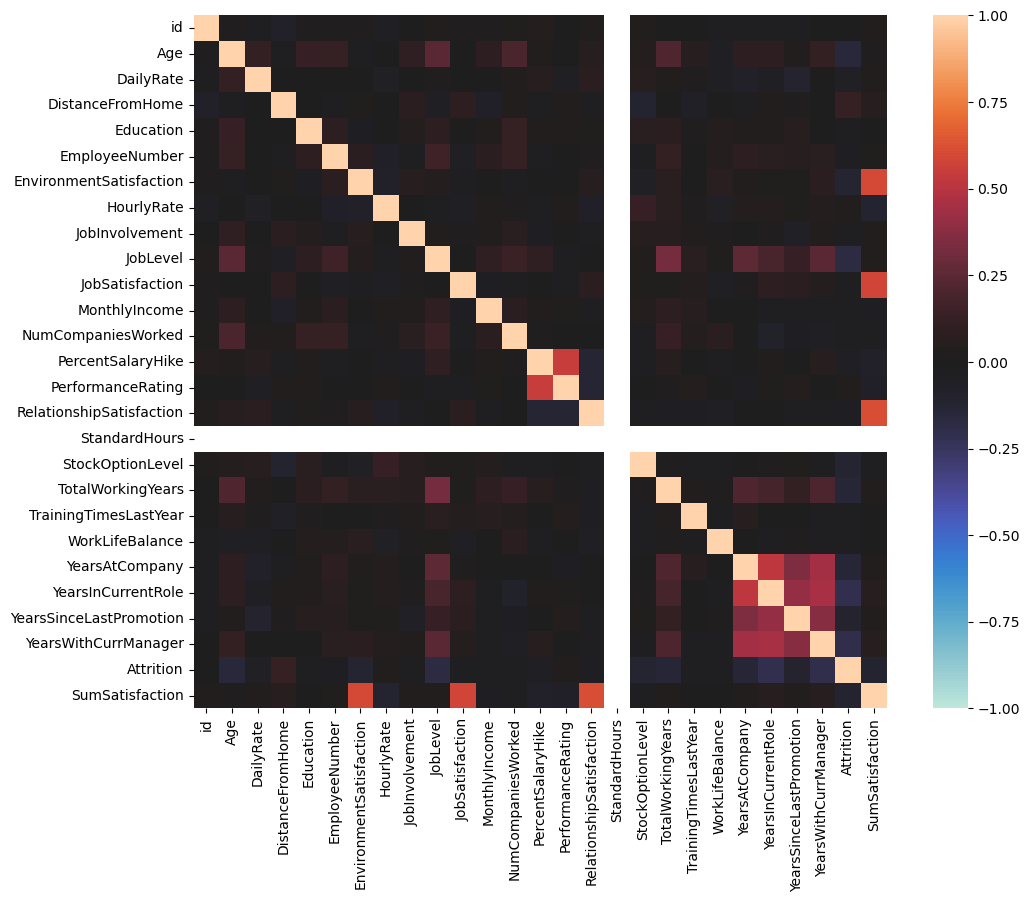

In [9]:
fig, ax = plt.subplots(figsize=(12, 9)) 
sns.heatmap(df_train.corr(numeric_only=True), square=True, vmax=1, vmin=-1, center=0)

In [43]:
df_train.groupby('Attrition').agg(['mean', 'std'])

/tmp/ipykernel_376/3989315790.py:1: FutureWarning: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_train.groupby('Attrition').agg(['mean', 'std'])


id                    Age             DailyRate  \
                  mean         std       mean       std        mean   
Attrition                                                             
0          1014.142857  566.915982  33.290780  7.988045  762.516700   
1          1008.131455  616.290456  29.971831  9.059507  696.248852   

                      DistanceFromHome           Education            \
                  std             mean       std      mean       std   
Attrition                                                              
0          413.197259         9.766468  7.918761  2.866261  1.085749   
1          422.290472        12.312491  8.786372  2.793427  0.933928   

          EmployeeNumber             EnvironmentSatisfaction            \
                    mean         std                    mean       std   
Attrition                                                                
0            1090.256332  572.319378                2.720365  1.144180   
1            1020.389671  613.460186                2.356808  1.070361   

          HourlyRate            JobInvolvement            JobLevel            \
                mean        std           mean       std      mean       std   
Attrition                                                                      
0          65.960486  20.708972       2.724417  0.676347  2.223911  1.200708   
1          67.657277  17.999211       2.680751  0.673946  1.671362  0.997628   

          JobSatisfaction           MonthlyIncome               \
                     mean       std          mean          std   
Attrition                                                        
0                2.731510  1.099442   7121.313070  5046.483131   
1                2.652582  1.055737   6733.755869  4973.220388   

          NumCompaniesWorked           PercentSalaryHike            \
                        mean       std              mean       std   
Attrition                                                            
0                   2.656535  2.471042         15.197568  3.541764   
1                   2.417840  2.406567         14.732394  4.012802   

          PerformanceRating           RelationshipSatisfaction            \
                       mean       std                     mean       std   
Attrition                                                                  
0                  3.106383  0.308483                 2.639311  1.064642   
1                  3.126761  0.333488                 2.511737  1.071106   

          StandardHours      StockOptionLevel           TotalWorkingYears  \
                   mean  std             mean       std              mean   
Attrition                                                                   
0                  80.0  0.0         0.913880  0.866131         11.119554   
1                  80.0  0.0         0.629108  0.878731          8.370892   

                    TrainingTimesLastYear          WorkLifeBalance            \
                std                  mean      std            mean       std   
Attrition                                                                      
0          7.645140              2.764944  1.24057        2.705167  0.712966   
1          7.687806              2.708920  1.32813        2.676056  0.653899   

          YearsAtCompany           YearsInCurrentRole            \
                    mean       std               mean       std   
Attrition                                                         
0               6.678825  5.171225           4.602837  3.696705   
1               4.835681  4.594525           2.610329  3.179131   

          YearsSinceLastPromotion           YearsWithCurrManager           \
                             mean       std                 mean      std   
Attrition                                                                   
0                        2.324215  3.434441             4.088146  3.30304   
1                        1.417840  2.

# Preprocessing

In [10]:
target_label = 'Attrition'
df_X = df_train.drop(columns=target_label)
df_y = df_train[[target_label]].copy()

In [11]:
unique_drop_list = ['id']
drop_list = ['Over18', 'StandardHours', 'EmployeeNumber']
df_X = df_X.drop(columns=unique_drop_list)
df_X = df_X.drop(columns=drop_list)

### Categorical data

In [12]:
category_list = [
    'BusinessTravel',
    'Department',
    'EducationField',
    'Gender',
    'JobRole',
    'MaritalStatus',
    'OverTime'
]
category_dict = dict()
for cate in category_list:
    categories = df_X[cate].unique().tolist()
    df_X[cate] = pd.Categorical(df_X[cate], categories=categories)
    category_dict[cate] = categories

df_X_categories = pd.get_dummies(df_X[category_list], drop_first=True)
df_X_categories

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,Department_Human Resources,Department_Sales,EducationField_Technical Degree,EducationField_Life Sciences,EducationField_Marketing,EducationField_Other,EducationField_Human Resources,Gender_Female,JobRole_Research Scientist,JobRole_Human Resources,JobRole_Manufacturing Director,JobRole_Sales Executive,JobRole_Sales Representative,JobRole_Healthcare Representative,JobRole_Research Director,JobRole_Manager,MaritalStatus_Divorced,MaritalStatus_Married,OverTime_Yes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1196,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
1197,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1198,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### Others (Not Categorical data)

In [13]:
df_X_others = df_X.select_dtypes(exclude='category')
df_X_others['SumSatisfaction'] = df_X_others[['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']].sum(axis=1)
df_X_others = df_X_others.drop(columns=['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction'])
df_X_others

,Age,DailyRate,DistanceFromHome,Education,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,SumSatisfaction
0,26,450.941476,7.601074,3,43,2,1,16307,1,13,3,0,1,3,2,11,8,7,0,9
1,47,730.235896,26.739489,3,98,2,1,9526,8,11,3,1,20,1,1,5,9,4,4,6
2,26,1082.560066,7.374739,3,84,2,1,10596,8,18,3,1,4,3,3,3,2,0,2,6
3,46,706.247579,14.791373,1,79,2,1,5762,0,20,4,1,6,0,1,5,4,7,7,8
4,25,500.610860,2.146966,4,98,3,2,17068,6,14,3,1,8,3,3,1,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,49,969.251891,13.243579,2,67,3,5,5098,8,18,3,0,33,3,2,3,2,1,2,10
1196,37,437.940367,2.339438,1,82,3,2,6434,1,11,3,0,6,5,2,9,2,0,8,12
1197,40,978.883360,10.214979,3,40,2,3,3339,1,12,3,1,19,2,3,14,9,9,9,8
1198,37,170.494984,2.639879,2,93,4,2,2011,0,16,3,2,6,5,3,3,2,0,3,6


## Recreate dataset

In [71]:
df_X = pd.concat([df_X_others, df_X_categories], axis=1)
features = [
    'DistanceFromHome',
    'SumSatisfaction',
    'HourlyRate',
    'PercentSalaryHike',
    'Age',
    'DailyRate',
    'MonthlyIncome',
    'YearsWithCurrManager',
    'JobLevel',
    'NumCompaniesWorked',
    'YearsAtCompany',
    'YearsInCurrentRole',
    # 'YearsSinceLastPromotion',
    'OverTime_Yes',
    # 'TotalWorkingYears',
    'StockOptionLevel'
]
df_X = df_X[features]
df_X

,DistanceFromHome,SumSatisfaction,HourlyRate,PercentSalaryHike,Age,DailyRate,MonthlyIncome,YearsWithCurrManager,JobLevel,NumCompaniesWorked,YearsAtCompany,YearsInCurrentRole,OverTime_Yes,StockOptionLevel
0,7.601074,9,43,13,26,450.941476,16307,0,1,1,11,8,0,0
1,26.739489,6,98,11,47,730.235896,9526,4,1,8,5,9,1,1
2,7.374739,6,84,18,26,1082.560066,10596,2,1,8,3,2,0,1
3,14.791373,8,79,20,46,706.247579,5762,7,1,0,5,4,1,1
4,2.146966,7,98,14,25,500.610860,17068,0,2,6,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,13.243579,10,67,18,49,969.251891,5098,2,5,8,3,2,0,0
1196,2.339438,12,82,11,37,437.940367,6434,8,2,1,9,2,1,0
1197,10.214979,8,40,12,40,978.883360,3339,9,3,1,14,9,0,1
1198,2.639879,6,93,16,37,170.494984,2011,3,2,0,3,2,0,2


In [72]:
X = df_X.copy()
y = df_y.copy()

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
# 学習データを学習用と検証用に分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y_train)

In [58]:
import analib.table
importlib.reload(analib.table)
from analib.table import benchmark
benchmark(X, y)

/code/signate_beginner36/../analib/table.py:202: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


RandomForest Accuracy score: 0.8291666666666667
XGBoost Accuracy score: 0.8291666666666667
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	train's binary_logloss: 0.178091	valid's binary_logloss: 0.390503
LightGBM Accuracy score: 0.825
CatBoost Accuracy score: 0.8416666666666667


In [ ]:
# %%capture output
# importlib.reload(analib.table)
# from analib.table import CatBoostModel
# catc = CatBoostModel(X_train, y_train,
#                      X_valid, y_valid,
#                      X_test, y_test)
# results = catc.turning(X_train, y_train)
# import pprint
# pprint.pprint(results.best_params_)

0:	learn: 0.6861112	total: 50.7ms	remaining: 25.3s
0:	learn: 0.6863919	total: 50.9ms	remaining: 25.4s
1:	learn: 0.6799188	total: 52.3ms	remaining: 13s
1:	learn: 0.6802772	total: 52.6ms	remaining: 13.1s
2:	learn: 0.6745676	total: 53.6ms	remaining: 8.88s
2:	learn: 0.6740638	total: 53.7ms	remaining: 8.9s
3:	learn: 0.6691226	total: 54.5ms	remaining: 6.76s
3:	learn: 0.6695137	total: 55.1ms	remaining: 6.84s
4:	learn: 0.6641000	total: 55.6ms	remaining: 5.5s
4:	learn: 0.6645524	total: 56ms	remaining: 5.54s
5:	learn: 0.6585767	total: 56.3ms	remaining: 4.63s
5:	learn: 0.6589481	total: 56.9ms	remaining: 4.68s
6:	learn: 0.6522700	total: 56.9ms	remaining: 4s
7:	learn: 0.6466186	total: 57.5ms	remaining: 3.54s
6:	learn: 0.6532746	total: 57.6ms	remaining: 4.06s
7:	learn: 0.6478137	total: 58.3ms	remaining: 3.58s
8:	learn: 0.6429846	total: 58.8ms	remaining: 3.21s
9:	learn: 0.6378931	total: 59.5ms	remaining: 2.91s
10:	learn: 0.6333072	total: 60ms	remaining: 2.67s
11:	learn: 0.6283197	total: 60.6ms	remain

In [73]:
output.show()

{'depth': 10, 'iterations': 500, 'l2_leaf_reg': 9, 'learning_rate': 0.1}


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [74]:
# CatBoost
importlib.reload(analib.table)
from analib.table import CatBoostModel
catb_params = {
    'loss_function': 'Logloss',    # 多値分類問題
    'iterations': 20000,
    'learning_rate': 0.01,
    'depth': 10,
    'l2_leaf_reg': 9,
    'early_stopping_rounds': 1000       # アーリーストッピングの回数
}
catc = CatBoostModel(X_train, y_train,
                     X_valid, y_valid,
                     X_test, y_test)
model = catc.train(params=catb_params)

In [75]:
y_pred = model.predict(X_test, prediction_type='Class')

In [76]:
# y_pred = (y_prob > 0.5).astype(int)

In [77]:
print(metrics.accuracy_score(y_test, y_pred))
metrics.precision_score(y_true=y_test, y_pred=y_pred)
metrics.recall_score(y_true=y_test, y_pred=y_pred)
metrics.f1_score(y_true=y_test, y_pred=y_pred)
print(metrics.classification_report(
    y_test,
    y_pred,
    target_names=['class_0', 'class_1'],
    digits=4
))

0.8333333333333334
              precision    recall  f1-score   support

     class_0     0.8458    0.9746    0.9057       197
     class_1     0.6154    0.1860    0.2857        43

    accuracy                         0.8333       240
   macro avg     0.7306    0.5803    0.5957       240
weighted avg     0.8045    0.8333    0.7946       240



In [78]:
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
TN = str(cm[0, 0]) + '(TN)'
FP = str(cm[0, 1]) + '(FP)'
FN = str(cm[1, 0]) + '(FN)'
TP = str(cm[1, 1]) + '(TP)'

pd.DataFrame(
    data=np.array([[TN, FP],
                   [FN, TP]]),
    index=['actual_Negative', 'acutal_Positive'],
    columns=['predict_Negative', 'predict_Positive']
)

,predict_Negative,predict_Positive
actual_Negative,192(TN),5(FP)
acutal_Positive,35(FN),8(TP)


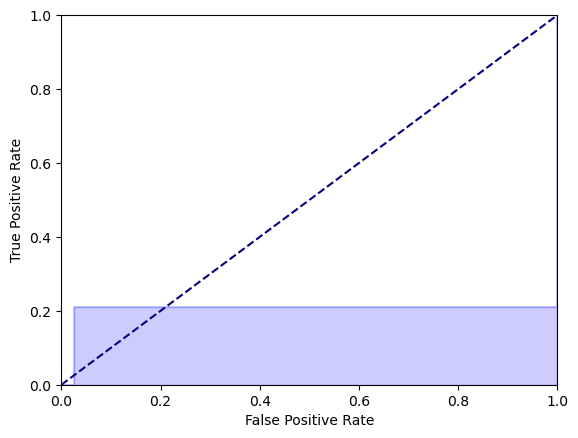

In [79]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.show()

0.49691306755260245


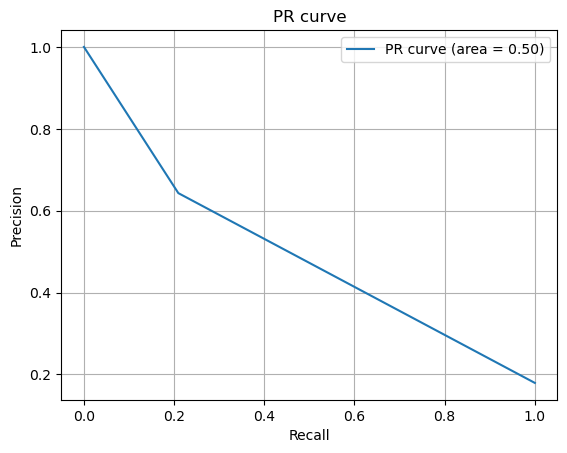

In [80]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_prob)

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

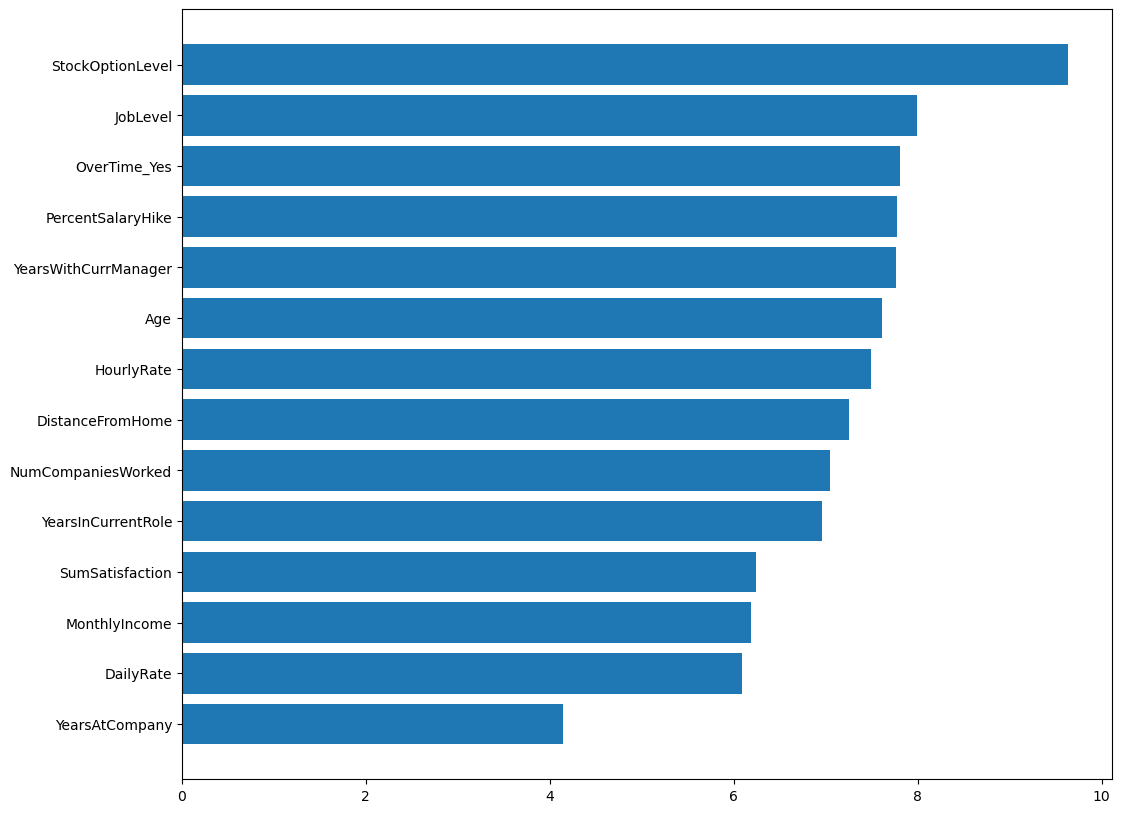

In [81]:
# 特徴量重要度
from catboost import Pool
feature = X.columns
# importance = np.array(model.feature_importance())
importance = np.array(model.get_feature_importance(Pool(X_train, y_train), type="PredictionValuesChange"))
df = pd.DataFrame({'feature': feature, 'importance': importance})
df = df.sort_values('importance', ascending=True)

n = len(df)  # 説明変数の項目数を取得
values = df['importance'].values
plt.figure(figsize=(12, 10))
plt.barh(range(n), values)

values = df['feature'].values
plt.yticks(np.arange(n), values) # x, y軸の設定

plt.show()

In [82]:
X_submit = preprocess(df_test)
y_pred_submit = model.predict(X_submit, prediction_type='Class')
# y_prob_submit = model.predict(X_submit, num_iteration=model.best_iteration)
# y_pred_submit = (y_prob_submit > 0.5).astype(int)
y_pred_submit

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [83]:
pd.concat(
    [df_test.iloc[:, 0], pd.DataFrame(y_pred_submit)],
    axis=1
).to_csv(
    f'output/{datetime.now().strftime("%Y%m%d%H%M%S")}.csv',
    header=False,
    index=False
)